In [ ]:
# default_exp utils.data

# Data Utilities
> Implementation of data utilities.

In [ ]:
#export
import pandas as pd
import numpy as np
import tempfile
import os
import scipy.stats as stats

from recohut.utils.common_utils import download_url

## List datasets

In [ ]:
#export
def list_datasets(top_n:int=None):
    """
    Retruns a pandas dataframe of all the available datasets and info

    Args:
        top_n (int): returns only top_n rows
    """
    url = 'https://docs.google.com/spreadsheets/d/1wY_83y2ltu6tzMNHFOQRNslrgb0VWH_wa7zP7lT6AvM/export?gid=0&format=csv'
    df = pd.read_csv(url, index_col=[0]).fillna('NA')
    if top_n:
        return df.head(top_n)
    return df

In [ ]:
list_datasets(top_n=3)

,url,nrows,columns,type,format,size (kb)
id,,,,,,
music30,https://github.com/RecoHut-Datasets/30music/ra...,3408682,"['session_id','user_id','ts','playtime']",pandas_df,parquet.snappy,32200
music30_sample,https://github.com/RecoHut-Datasets/30music/ra...,343182,"['session_id','user_id','ts','playtime']",pandas_df,parquet.snappy,10100
sample_session,https://github.com/RecoHut-Datasets/sample/raw...,5,"['session_id','sequence','ts','user_id']",pandas_df,parquet.snappy,NA


## Load dataset

In [ ]:
#export
def load_dataset(data_id, data_dir=None, log=False):
    dataset_list = list(list_datasets().index)
    assert data_id in dataset_list, f'data id not exist, available ids are {dataset_list}'

    if data_dir is None:
        data_dir = os.path.join(tempfile.gettempdir(), data_id)
    
    data_info = list_datasets().loc[data_id]
    path = download_url(data_info.url, data_dir, log=log)

    if data_info.format == 'parquet.snappy':
        df = pd.read_parquet(path)
    
    return df

In [ ]:
df = load_dataset('music30_sample')
df.head()

,session_id,user_id,song_id,ts,playtime
0,1902204,4,16,1421163674,274
1,1902204,4,17,1421163948,250
2,1902204,4,18,1421164198,271
3,780919,10,60,1411009500,228
4,780919,10,61,1411014936,206


## Generate dataset

### generate_time_series

In [ ]:
#export
def generate_time_series(batch_size, n_steps, seed=42):
    np.random.seed(seed)
    freq1, freq2, offsets1, offsets2 = np.random.rand(4, batch_size, 1)
    time = np.linspace(0, 1, n_steps)
    series = 0.5 * np.sin((time - offsets1) * (freq1 * 10 + 10))  #   wave 1
    series += 0.2 * np.sin((time - offsets2) * (freq2 * 20 + 20)) # + wave 2
    series += 0.1 * (np.random.rand(batch_size, n_steps) - 0.5)   # + noise
    return series[..., np.newaxis].astype(np.float32)

In [ ]:
n_steps = 50
series = generate_time_series(10000, n_steps + 1)
X_train, y_train = series[:7000, :n_steps], series[:7000, -1]
X_valid, y_valid = series[7000:9000, :n_steps], series[7000:9000, -1]
X_test, y_test = series[9000:, :n_steps], series[9000:, -1]

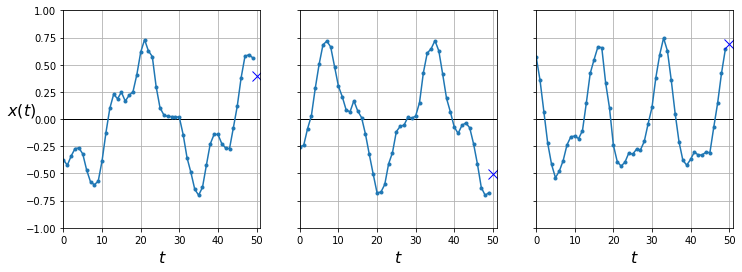

In [ ]:
import matplotlib.pyplot as plt

def plot_series(series, y=None, y_pred=None, x_label="$t$", y_label="$x(t)$"):
    plt.plot(series, ".-")
    if y is not None:
        plt.plot(n_steps, y, "bx", markersize=10)
    if y_pred is not None:
        plt.plot(n_steps, y_pred, "ro")
    plt.grid(True)
    if x_label:
        plt.xlabel(x_label, fontsize=16)
    if y_label:
        plt.ylabel(y_label, fontsize=16, rotation=0)
    plt.hlines(0, 0, 100, linewidth=1)
    plt.axis([0, n_steps + 1, -1, 1])

fig, axes = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(12, 4))

for col in range(3):
    plt.sca(axes[col])
    plot_series(X_valid[col, :, 0], y_valid[col, 0],
                y_label=("$x(t)$" if col==0 else None))

plt.show()

### generate_abtest_data

In [ ]:
#export
def generate_abtest_data(N_A, N_B, bcr, d_hat, days=None, control_label='A',
                         test_label='B', seed=None):
    """Returns a pandas dataframe with synthetic A/B experiment data
    Example:
    Parameters:
        N_A (int): sample size for control group
        N_B (int): sample size for test group
            Note: final sample size may not match N_A provided because the
            group at each row is chosen at random (50/50).
        bcr (float): baseline conversion rate; conversion rate of control group
        d_hat (float): difference between the groups
        days (int): optional; if provided, a column for 'ts' will be included
            to divide the data in chunks of time
            Note: overflow data will be included in an extra day
        control_label (str)
        test_label (str)
        seed (int)
    Returns:
        pd.DataFrame: the generated ctr dataframe
        pd.DataFrame: summary dataframe
    """
    p_A = bcr
    p_B = bcr + d_hat # conversion rate of test group

    if seed:
        np.random.seed(seed)

    # initiate empty container
    data = []

    # total amount of rows in the data
    N = N_A + N_B

    # distribute events based on proportion of group size
    group_bern = stats.bernoulli(N_A / (N_A + N_B))

    # initiate bernoulli distributions from which to randomly sample
    A_bern = stats.bernoulli(p_A)
    B_bern = stats.bernoulli(p_B)

    for idx in range(N):
        # initite empty row
        row = {}
        # for 'ts' column
        if days is not None:
            if type(days) == int:
                row['ts'] = idx // (N // days)
            else:
                raise ValueError("Provide an integer for the days parameter.")
        # assign group based on 50/50 probability
        row['group'] = group_bern.rvs()

        if row['group'] == 0:
            # assign conversion based on provided parameters
            row['converted'] = A_bern.rvs()
        else:
            row['converted'] = B_bern.rvs()
        # collect row into data container
        data.append(row)

    # convert data into pandas dataframe
    df = pd.DataFrame(data)

    # transform group labels of 0s and 1s to user-defined group labels
    df['group'] = df['group'].apply(
        lambda x: control_label if x == 0 else test_label)
    
    # summary dataframe
    ab_summary = df.pivot_table(values='converted', index='group', aggfunc=np.sum)
    # add additional columns to the pivot table
    ab_summary['total'] = df.pivot_table(values='converted', index='group', aggfunc=lambda x: len(x))
    ab_summary['rate'] = df.pivot_table(values='converted', index='group')

    return df, ab_summary

In [ ]:
ab_data, ab_summary = generate_abtest_data(1000, 1000, 0.4, 0.3, seed=35)
ab_summary = ab_summary.reset_index().to_dict(orient='records')

expected_df = [{'converted': 426, 'group': 'A', 'rate': 0.4108003857280617, 'total': 1037},
            {'converted': 671, 'group': 'B', 'rate': 0.6967808930425753, 'total': 963}]

test_eq(ab_summary, expected_df)